<a href="https://colab.research.google.com/github/Kaaviya-E/Adaptive-HARQ-Scheduling-for-5G-IoT-in-Non-Terrestrial-Networks/blob/main/harq_step3_sweep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install simpy


Starting sweep 10 x 5 = 50 runs...
[1/50] Running tbphc=1, reps=1 ... done. success_rate=1.000, thr=761904.8bps
[2/50] Running tbphc=1, reps=2 ... done. success_rate=1.000, thr=761904.8bps
[3/50] Running tbphc=1, reps=3 ... done. success_rate=1.000, thr=761904.8bps
[4/50] Running tbphc=1, reps=4 ... done. success_rate=1.000, thr=761904.8bps
[5/50] Running tbphc=1, reps=5 ... done. success_rate=1.000, thr=761904.8bps
[6/50] Running tbphc=2, reps=1 ... done. success_rate=1.000, thr=761904.8bps
[7/50] Running tbphc=2, reps=2 ... done. success_rate=1.000, thr=761904.8bps
[8/50] Running tbphc=2, reps=3 ... done. success_rate=1.000, thr=761904.8bps
[9/50] Running tbphc=2, reps=4 ... done. success_rate=1.000, thr=761904.8bps
[10/50] Running tbphc=2, reps=5 ... done. success_rate=1.000, thr=761904.8bps
[11/50] Running tbphc=3, reps=1 ... done. success_rate=1.000, thr=761904.8bps
[12/50] Running tbphc=3, reps=2 ... done. success_rate=1.000, thr=761904.8bps
[13/50] Running tbphc=3, reps=3 ... do

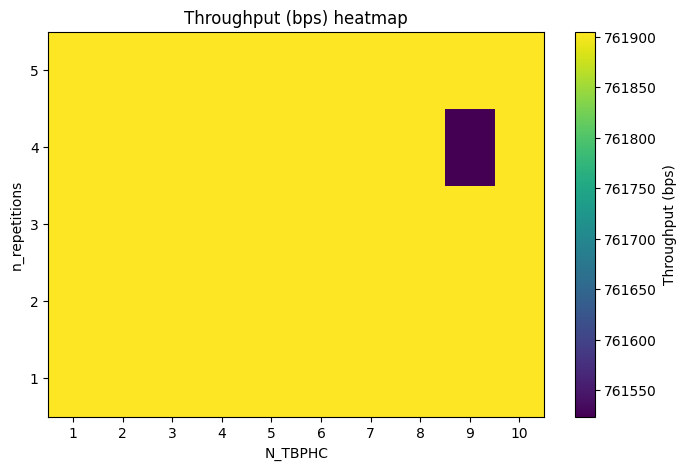

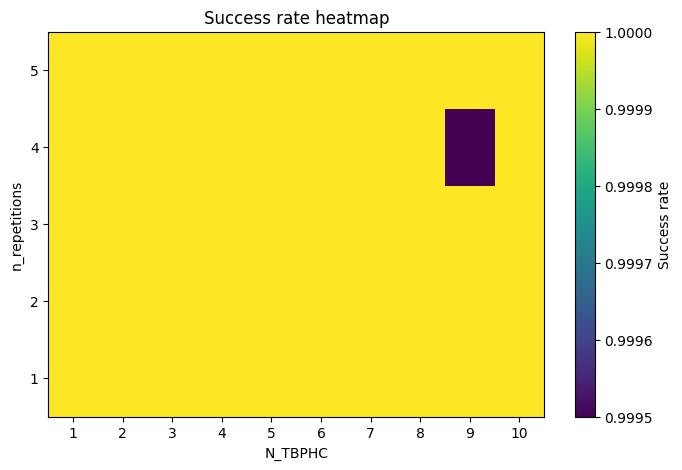

In [ ]:
# harq_step3_sweep.py
import os
import time
import joblib
import numpy as np
import pandas as pd
import simpy
import matplotlib.pyplot as plt
from collections import defaultdict

# ----------------- USER CONFIG -----------------
CSV = "ntn_harq_dataset.csv"
DELAY_MODEL_PATH = "rf_dd2a_ug2d_model.pkl"

NUM_PACKETS = 2000             # number of packets per simulation (increase for stability)
PACKET_INTERVAL_MS = 10        # inter-arrival at BS (ms)
MAX_RETX = 3
HARQ_TIMEOUT_MS = 200
PROP_MS_DEFAULT = 10.0
PACKET_LOSS_PROB = 0.05
RANDOM_SEED = 42
ASSUME_PRED_IN_MS = True       # change if your predictor outputs subframes
PAYLOAD_BYTES = 1000           # payload per packet to compute throughput (bytes)
USE_RTT_IF_PRESENT = True
# Sweep ranges (tune them)
N_TBPHC_RANGE = np.arange(1, 11, 1)   # 1..10
N_REP_RANGE = np.arange(1, 6, 1)      # 1..5
OUT_DIR = "harq_sweep_outputs"
# ----------------------------------------------

np.random.seed(RANDOM_SEED)

os.makedirs(OUT_DIR, exist_ok=True)

# ---------- Load dataset + model ----------
if not os.path.exists(CSV):
    raise FileNotFoundError(f"CSV not found: {CSV}")
if not os.path.exists(DELAY_MODEL_PATH):
    raise FileNotFoundError(f"Delay model not found: {DELAY_MODEL_PATH}")

df = pd.read_csv(CSV)
delay_model = joblib.load(DELAY_MODEL_PATH)

# compute numeric mean and categorical mode for default inputs
numeric_means = df.select_dtypes(include=[np.number]).mean()
modes = df.mode().iloc[0] if not df.mode().empty else pd.Series(dtype=object)

# helper to build vectorized features for num_packets with overrides (tbphc, reps)
def build_feature_matrix(num_packets, base_mean, base_mode, tbphc=None, reps=None, jitter=True):
    # Start with numeric means replicated
    numeric = base_mean.copy()
    # convert to dict then DataFrame
    base_row = numeric.to_dict()
    # add categorical defaults
    for c in base_mode.index:
        if c not in base_row:
            base_row[c] = base_mode[c]
    # build DataFrame
    X = pd.DataFrame([base_row] * num_packets)
    # Optionally add jitter to simulate variations
    if jitter:
        if "RTT_ms" in X.columns:
            X["RTT_ms"] = X["RTT_ms"] * (1 + np.random.normal(0, 0.05, size=num_packets))
        if "SNR_dB" in X.columns:
            X["SNR_dB"] = X["SNR_dB"] + np.random.normal(0, 1.0, size=num_packets)
    # override tbphc/reps if requested
    if tbphc is not None:
        if "N_TBPHC" in X.columns:
            X["N_TBPHC"] = tbphc
        else:
            X["N_TBPHC"] = tbphc
    if reps is not None:
        if "n_repetitions" in X.columns:
            X["n_repetitions"] = reps
        else:
            X["n_repetitions"] = reps
    return X

# ---------- Vectorized predict helper ----------
def vectorized_predict(model, X_df):
    """
    Predict n_DD2A, n_UG2D for a DataFrame X_df. Returns two 1-D numpy arrays.
    """
    preds = model.predict(X_df)  # expect shape (N,2) or (N,) if weird
    arr = np.asarray(preds)
    if arr.ndim == 1:
        # fallback: maybe model predicted single column or (N,) shape; try reshape
        raise ValueError("Predict returned 1D output; expected 2 columns. Got shape: " + str(arr.shape))
    if arr.shape[1] >= 2:
        n_dd2a = arr[:, 0].astype(float)
        n_ug2d = arr[:, 1].astype(float)
        return n_dd2a, n_ug2d
    else:
        raise ValueError("Predict returned fewer than 2 columns: " + str(arr.shape))

# ---------- Fast sim that consumes precomputed delays ----------
class FastHARQSim:
    def __init__(self, env, predicted_ack_delay_s_arr, num_packets, interval_ms,
                 packet_loss_prob=0.05, harq_timeout_s=0.2, prop_ms_default=10.0):
        self.env = env
        self.pred_delays = predicted_ack_delay_s_arr
        self.num_packets = num_packets
        self.interval_s = interval_ms / 1000.0
        self.packet_loss_prob = packet_loss_prob
        self.harq_timeout_s = harq_timeout_s
        self.prop_ms_default = prop_ms_default
        self.stats = defaultdict(list)
        self._pkt_idx = 0

    def start(self):
        self.env.process(self._bs_sender())

    def _bs_sender(self):
        for i in range(self.num_packets):
            self.env.process(self._handle_packet(i))
            yield self.env.timeout(self.interval_s)

    def _handle_packet(self, idx):
        send_time = self.env.now
        attempts = 0
        success = False
        # each attempt uses same predicted delay for simplicity (precomputed)
        predicted_delay_s = self.pred_delays[idx]  # seconds (already includes prop)
        while attempts <= MAX_RETX and not success:
            attempts += 1
            # physical loss check
            phys_loss = np.random.rand() < self.packet_loss_prob
            if phys_loss:
                # wait for HARQ timeout
                yield self.env.timeout(self.harq_timeout_s)
            else:
                # If predicted delay <= HARQ timeout, ACK arrives before timeout
                if predicted_delay_s <= self.harq_timeout_s:
                    # wait for the predicted ack delay
                    yield self.env.timeout(predicted_delay_s)
                    success = True
                    self.stats["packet"].append(idx)
                    self.stats["attempts"].append(attempts)
                    self.stats["success_time_s"].append(self.env.now - send_time)
                    break
                else:
                    # ACK would arrive after timeout => timeout first
                    yield self.env.timeout(self.harq_timeout_s)
                    # will retransmit if attempts left
        if not success:
            self.stats["packet"].append(idx)
            self.stats["attempts"].append(attempts)
            self.stats["success_time_s"].append(None)

# ---------- Single-run helper returning metrics ----------
def run_single_config(tbphc, reps, num_packets=NUM_PACKETS):
    # 1) Build feature matrix
    X = build_feature_matrix(num_packets, numeric_means, modes, tbphc=tbphc, reps=reps, jitter=True)
    # 2) Predict vectorized
    n_dd2a_arr, n_ug2d_arr = vectorized_predict(delay_model, X)
    # 3) Convert to total predicted ack arrival delay (ms -> s)
    # Use propagation: if RTT_ms in numeric_means use RTT/2 else use default
    if USE_RTT_IF_PRESENT and "RTT_ms" in numeric_means.index:
        prop_ms = float(numeric_means["RTT_ms"]) / 2.0
    else:
        prop_ms = PROP_MS_DEFAULT
    total_delay_ms = n_dd2a_arr + n_ug2d_arr + prop_ms
    total_delay_s = total_delay_ms / 1000.0
    # Clip to non-negative
    total_delay_s = np.maximum(0.0, total_delay_s)
    # 4) Run fast sim
    env = simpy.Environment()
    sim = FastHARQSim(env, total_delay_s, num_packets, PACKET_INTERVAL_MS,
                      packet_loss_prob=PACKET_LOSS_PROB,
                      harq_timeout_s=HARQ_TIMEOUT_MS/1000.0,
                      prop_ms_default=prop_ms)
    sim.start()
    env.run()
    # 5) Compute metrics
    stats = sim.stats
    df_res = pd.DataFrame({
        "packet": stats["packet"],
        "attempts": stats["attempts"],
        "success_time_s": stats["success_time_s"]
    })
    total = len(df_res)
    succeeded = df_res["success_time_s"].notna().sum()
    success_rate = succeeded / total
    avg_attempts = df_res["attempts"].mean()
    # mean latency (only successful)
    mean_latency_s = df_res["success_time_s"].dropna().mean() if succeeded > 0 else None
    # throughput in bps = (successful packets * payload bits) / total sim time
    # approximate sim time: last event time ~ total packets * inter-arrival + some slack
    sim_time_s = num_packets * (PACKET_INTERVAL_MS / 1000.0) + 1.0
    payload_bits = PAYLOAD_BYTES * 8
    throughput_bps = (succeeded * payload_bits) / sim_time_s
    return {
        "N_TBPHC": tbphc,
        "n_repetitions": reps,
        "success_rate": success_rate,
        "avg_attempts": avg_attempts,
        "mean_latency_s": mean_latency_s,
        "throughput_bps": throughput_bps,
        "succeeded": int(succeeded),
        "total_packets": int(total)
    }

# ---------- Run sweep ----------
results = []
start_time = time.time()
total_iters = len(N_TBPHC_RANGE) * len(N_REP_RANGE)
iter_i = 0
print(f"Starting sweep {len(N_TBPHC_RANGE)} x {len(N_REP_RANGE)} = {total_iters} runs...")
for tb in N_TBPHC_RANGE:
    for rp in N_REP_RANGE:
        iter_i += 1
        print(f"[{iter_i}/{total_iters}] Running tbphc={tb}, reps={rp} ...", end="")
        res = run_single_config(tb, rp, num_packets=NUM_PACKETS)
        results.append(res)
        print(f" done. success_rate={res['success_rate']:.3f}, thr={res['throughput_bps']:.1f}bps")
elapsed = time.time() - start_time
print("Sweep finished in", elapsed, "s")

# Save CSV
results_df = pd.DataFrame(results)
csv_out = os.path.join(OUT_DIR, "harq_sweep_results.csv")
results_df.to_csv(csv_out, index=False)
print("Saved sweep CSV:", csv_out)

# ---------- Produce heatmaps ----------
pivot_thr = results_df.pivot(index="n_repetitions", columns="N_TBPHC", values="throughput_bps")
pivot_sr = results_df.pivot(index="n_repetitions", columns="N_TBPHC", values="success_rate")

plt.figure(figsize=(8,5))
plt.title("Throughput (bps) heatmap")
plt.xlabel("N_TBPHC")
plt.ylabel("n_repetitions")
plt.imshow(pivot_thr, origin="lower", aspect="auto")
plt.colorbar(label="Throughput (bps)")
plt.xticks(np.arange(len(pivot_thr.columns)), pivot_thr.columns)
plt.yticks(np.arange(len(pivot_thr.index)), pivot_thr.index)
plt.savefig(os.path.join(OUT_DIR, "heatmap_throughput.png"))
print("Saved heatmap:", os.path.join(OUT_DIR, "heatmap_throughput.png"))

plt.figure(figsize=(8,5))
plt.title("Success rate heatmap")
plt.xlabel("N_TBPHC")
plt.ylabel("n_repetitions")
plt.imshow(pivot_sr, origin="lower", aspect="auto")
plt.colorbar(label="Success rate")
plt.xticks(np.arange(len(pivot_sr.columns)), pivot_sr.columns)
plt.yticks(np.arange(len(pivot_sr.index)), pivot_sr.index)
plt.savefig(os.path.join(OUT_DIR, "heatmap_success_rate.png"))
print("Saved heatmap:", os.path.join(OUT_DIR, "heatmap_success_rate.png"))

print("All outputs in folder:", OUT_DIR)
